In [2]:
import numpy as np
import matplotlib.pyplot as plt
from aeons.utils import *
from aeons.regress import *
from aeons.endpoint import *
from aeons.plotting import *
figsettings()

In [3]:
name, samples = get_samples('lcdm', 'planck')
model = EndModel(samples)
true_endpoint = model.true_endpoint()
true_logXf = model.true_logXf()

In [7]:
def get_logXfs(model, method, iterations, **kwargs):
    """Method takes in arguments (ndead, logL, nk, logZdead, **kwargs) and returns logXfs_set"""
    N = len(iterations)
    logXfs = np.zeros(N)
    logXfs_std = np.zeros(N)
    for i, ndead in enumerate(iterations):
        logL, X_mean, nk, logZdead = model.data(ndead)
        try:
            logXfs_set, message = method(ndead, logL, nk, logZdead, **kwargs)
            logXfs[i] = np.mean(logXfs_set)
            logXfs_std[i] = np.std(logXfs_set)
            print('\r', f"Iteration {ndead} of {iterations[-1]}, {len(logXfs_set)} samples", end='')
        except:
            logXfs[i] = np.nan
            logXfs_std[i] = np.nan
            print('\r', f"Iteration {ndead} of {iterations[-1]}, NaN", end='')
    return logXfs, logXfs_std

In [39]:
Nset = 25
iterations = make_iterations(true_endpoint, 10)
logXfs = np.zeros(len(iterations))
logXfs_std = np.zeros(len(iterations))
for i, ndead in enumerate(iterations):
    logL, X_mean, nk, logZdead = model.data(ndead)
    # Test if we need to use BMD
    BMD = False
    theta = analytic_lm_params(logL[ndead:], X_mean[ndead:], d0=1)
    if np.isnan(logXf_formula(theta, logZdead, X_mean[ndead])):
        BMD = True
    if BMD:
        print('\n', f'{ndead}, BMD \n')
        points = model.points(ndead)
        beta = get_beta(points, ndead)
        dG = points.set_beta(beta).d_G(10)
        logXf_set = np.zeros(Nset)
        for j in range(Nset):
            # Randomly choose a dG
            d = np.random.choice(dG)
            X = generate_Xs(nk)
            theta = params_from_d(logL[ndead:], X[ndead:], d)
            logXf_set[j] = logXf_formula(theta, logZdead, X_mean[ndead])
    else:
        logXf_set = np.zeros(Nset)
        for j in range(Nset):
            X = generate_Xs(nk)
            theta = analytic_lm_params(logL[ndead:], X[ndead:], d0=1)
            logXf_set[j] = logXf_formula(theta, logZdead, X_mean[ndead])
    logXf_set = logXf_set[~np.isnan(logXf_set)]
    # logXf_set = reject_outliers(logXf_set, 3)
    logXfs[i] = np.mean(logXf_set)
    logXfs_std[i] = np.std(logXf_set)
    print('\r', f"Iteration {ndead} of {iterations[-1]}", end='')

 Iteration 41020 of 51921

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/scipy/special/_logsumexp.py:111: RuntimeWarning: overflow encountered in exp
  tmp = np.exp(a - a_max)
/home/zixiao/Documents/III/project/aeons/aeons/utils.py:118: RuntimeWarning: invalid value encountered in scalar divide
  xf_reg = gammaincinv(d/2, np.exp(logend)/gamma(d/2))


 Iteration 51921 of 51921

In [7]:
def get_beta_max(points, ndead):
    def func(beta):
        return -points.set_beta(beta).d_G()
    from scipy.optimize import minimize_scalar
    return minimize_scalar(func, bounds=(0, 1), method='bounded').x

In [3]:
name, samples = get_samples('toy', 'cauchy_84')
model  = EndModel(samples)
true_endpoint = model.true_endpoint()
true_logXf = model.true_logXf()

In [68]:
true_endpoint, samples.d_G(10).mean(), samples.d_G(10).std()

(39236, 188.55188848065066, 22.600277970115282)

In [ ]:
ds = [8, 16, 32]
for i, d in enumerate(ds):
    name, samples = get_samples('toy', f'gauss_{d}')
    model  = EndModel(samples)
    true_endpoint = model.true_endpoint()
    true_logXf = model.true_logXf()
    iterations = make_iterations(true_endpoint, 50)
    logXfs, logXfs_std = model.logXfs(theta_basic, iterations, Nset=25)
    write_to_txt(f'{aeons_dir}/data/predictions/gauss/basic/gauss_{d}.txt', [iterations, logXfs, logXfs_std, true_endpoint])
    print(f'{d} done, {i+1} of {len(ds)}')

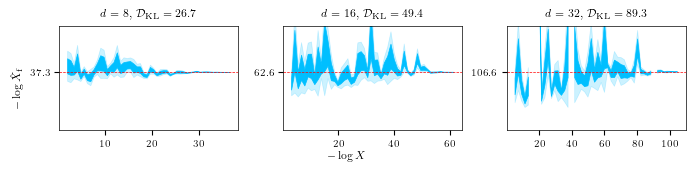

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(7, 1.8))
axs = axs.flatten()
for i, nDims in enumerate(ds):
    name, samples = get_samples('toy', f'gauss_{nDims}')
    iterations, logXfs, logXfs_std, true_endpoint = read_from_txt(f'{aeons_dir}/data/predictions/gauss/basic/gauss_{nDims}.txt')
    logXf_true = samples.logX().iloc[int(true_endpoint[0])]
    logXs = samples.logX().iloc[iterations]
    # endpoints, endpoints_std = calc_endpoints(iterations, logXs, logXfs, logXfs_std, nlive=500)
    plot_std(-logXs, -logXfs, logXfs_std, -logXf_true, ylim=(0, 1.8), ax=axs[i])
    axs[i].set_title(rf'$d$ = {nDims}, $\mathcal{{D}}_\mathrm{{KL}} = {samples.D_KL():.1f}$', fontsize=8)
    axs[i].set_yticks([-logXf_true], [f"{-logXf_true:.1f}"])
fig.supxlabel('$-\\log X$', y=0.1, fontsize=8)
fig.supylabel('$-\\log \\hat{X}_\\mathrm{f}$',  fontsize=8)
fig.tight_layout()

In [7]:
model  = EndModel(samples)
true_endpoint = model.true_endpoint()
true_logXf = model.true_logXf()

 Iteration 17440 of 17440, 24 samples

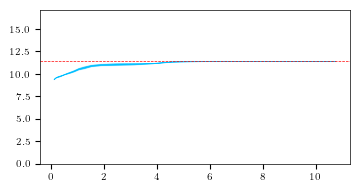

In [9]:
iterations = make_iterations(true_endpoint, 25)
logXfs, logXfs_std = model.logXfs(theta_basic, iterations, Nset=25)
logXs = samples.logX().iloc[iterations]
plot_std(-logXs, -logXfs, logXfs_std, -true_logXf, (0, 1.5))